# LSTM for Time Series
### With TensorFlow/Keras: One step forecasting

## Imports

In [78]:
from utilities.std_imports import *
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow.keras as tfk

## Load data

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64


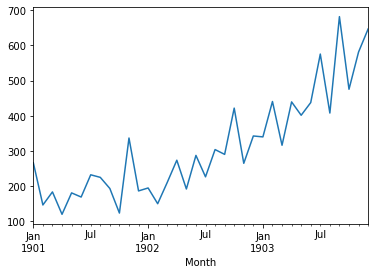

In [79]:
series = pd.read_csv('D:/data/csv/shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=lambda x: datetime.strptime('190'+x, '%Y-%m'))

print(series.head())
series.plot()
plt.show()

In [80]:
# split data into train and test
X = series.values
train, test = X[0:-12], X[-12:]

## Naïve Forecast

RMSE: 136.761


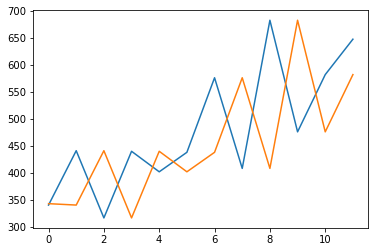

In [81]:
hist = [x for x in train]
pred = list()
for i in range(len(test)):
    pred.append(hist[-1])
    hist.append(test[i])

rmse = sqrt(mean_squared_error(test, pred))
print('RMSE: %.3f' % rmse)
# line plot of observed vs predicted
plt.plot(test)
plt.plot(pred)
plt.show()

In [82]:
def ts2sup_df(data, lag=1):
    df = pd.DataFrame(data)
    cols = [df.shift(t) for t in range(1, lag+1)]
    cols.append(df)
    df = pd.concat(cols, axis=1)
    df.fillna(0, inplace=True)
    return df

In [83]:
X = series.values
supervised = ts2sup_df(X, 1)
print(supervised.head())

       0      0
0    0.0  266.0
1  266.0  145.9
2  145.9  183.1
3  183.1  119.3
4  119.3  180.3


## Stationarization

Time series differentiation and inverse (back to original)

In [84]:
def diff(ds, span=1):
    diff_ts = list()
    for i in range(span, len(ds)):
        value = ds[i] - ds[i-span]
        diff_ts.append(value)
    return pd.Series(diff_ts)

def inverse_diff(hist, pred, span=1):
    return pred + hist[-span]

Testing the stationarization functions

In [85]:
diff_ts = diff(series, 1)
print(diff_ts.head())

inv_diff_ts = list()
for i in range(len(diff_ts)):
    value = inverse_diff(series, diff_ts[i], len(series)-i)
    inv_diff_ts.append(value)
    inv_diff = pd.Series(inv_diff_ts)
print(inv_diff.head())

0   -120.1
1     37.2
2    -63.8
3     61.0
4    -11.8
dtype: float64
0    145.9
1    183.1
2    119.3
3    180.3
4    168.5
dtype: float64


## Scaling

In [86]:
def scale(train, test):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

X = series.values
X = X.reshape(len(X), 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(X)
scaled_X = scaler.transform(X)
scaled_series = pd.Series(scaled_X[:, 0])
print(scaled_series.head())

inverted_X = scaler.inverse_transform(scaled_X)
inverted_series = pd.Series(inverted_X[:, 0])
print(inverted_series.head())

0   -0.478585
1   -0.905456
2   -0.773236
3   -1.000000
4   -0.783188
dtype: float64
0    266.0
1    145.9
2    183.1
3    119.3
4    180.3
dtype: float64


## Modelling

In [87]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = tfk.models.Sequential()
    model.add(tfk.layers.LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(tfk.layers.Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

def one_step_fcst(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    pred = model.predict(X, batch_size=batch_size)
    return pred[0,0]

## Testing

In [88]:
# differentiation
raw_values = series.values
diff_values = diff(raw_values, 1)
 
# ts to supervised
sup_df = ts2sup_df(diff_values, 1).values
 
# split train/test
train, test = sup_df[0:-12], sup_df[-12:]
 
# scaling
scaler, train_scaled, test_scaled = scale(train, test)
 
# fit the model
lstm = fit_lstm(train_scaled, 1, 3000, 4)

# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm.predict(train_reshaped, batch_size=1)

array([[-0.74417055],
       [-0.17301072],
       [-0.6798173 ],
       [-0.13206328],
       [-0.38989562],
       [-0.05658899],
       [-0.14585601],
       [ 0.15577097],
       [ 0.27285677],
       [ 0.38315284],
       [-0.82870394],
       [ 0.41384548],
       [-0.02453728],
       [ 0.27768415],
       [-0.10198806],
       [-0.38771206],
       [ 0.5976974 ],
       [-0.3691802 ],
       [ 0.07988979],
       [-0.87052876],
       [ 0.12972595],
       [-0.6946604 ],
       [ 0.3929364 ]], dtype=float32)

## Validation

Month	Predicted	Expected
1 	 353.905 	 339.7
2 	 473.224 	 440.4
3 	 434.090 	 315.9
4 	 482.595 	 439.3
5 	 435.837 	 401.3
6 	 563.285 	 437.4
7 	 590.945 	 575.5
8 	 428.623 	 407.6
9 	 513.556 	 682.0
10 	 558.361 	 475.3
11 	 528.541 	 581.3
12 	 467.984 	 646.9

Test RMSE: 93.501 



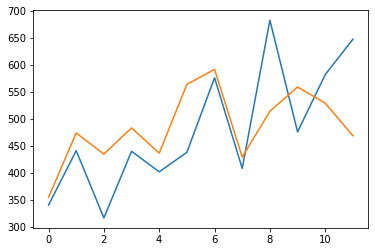

In [89]:
pred = list()
print('Month\tPredicted\tExpected')
for i in range(len(test_scaled)):
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    p = one_step_fcst(lstm, 1, X)
    p = invert_scale(scaler, X, p)
    p = inverse_diff(raw_values, p, len(test_scaled)+1-i)
    pred.append(p)
    exp = raw_values[len(train) + i + 1]
    print(i+1, '\t', '{:.3f}'.format(p), '\t',exp)
 
rmse = sqrt(mean_squared_error(raw_values[-12:], pred))
print('\nTest RMSE: %.3f' % rmse, '\n')

pyplot.plot(raw_values[-12:])
pyplot.plot(pred)
pyplot.show()

## Credits & Links

https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/
https://colah.github.io/posts/2015-08-Understanding-LSTMs/
https://towardsdatascience.com/machine-learning-recurrent-neural-networks-and-long-short-term-memory-lstm-python-keras-example-86001ceaaebc